In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import nltk
from collections import Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score, classification_report
from keybert import KeyBERT
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import Dataset


In [190]:
df = pd.read_csv("C:\\AIML\\mtsamples.csv")


print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         4999 non-null   int64 
 1   description        4999 non-null   object
 2   medical_specialty  4999 non-null   object
 3   sample_name        4999 non-null   object
 4   transcription      4966 non-null   object
 5   keywords           3931 non-null   object
dtypes: int64(1), object(5)
memory usage: 234.5+ KB
None
Unnamed: 0              0
description             0
medical_specialty       0
sample_name             0
transcription          33
keywords             1068
dtype: int64


In [191]:
# Preview the dataset
df.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [192]:
# for this classification project , retain only the 'transcription' (text data) and 'medical_specialty' (target label) columns
# there are 33 null values for the medical transcriptions text , Fill them with unknown values 
# Drop rows with missing transcription
df = df.dropna(subset=['transcription'])

# Drop unnecessary columns
df = df[['medical_specialty', 'transcription']]
df.fillna('Unknown', inplace=True)

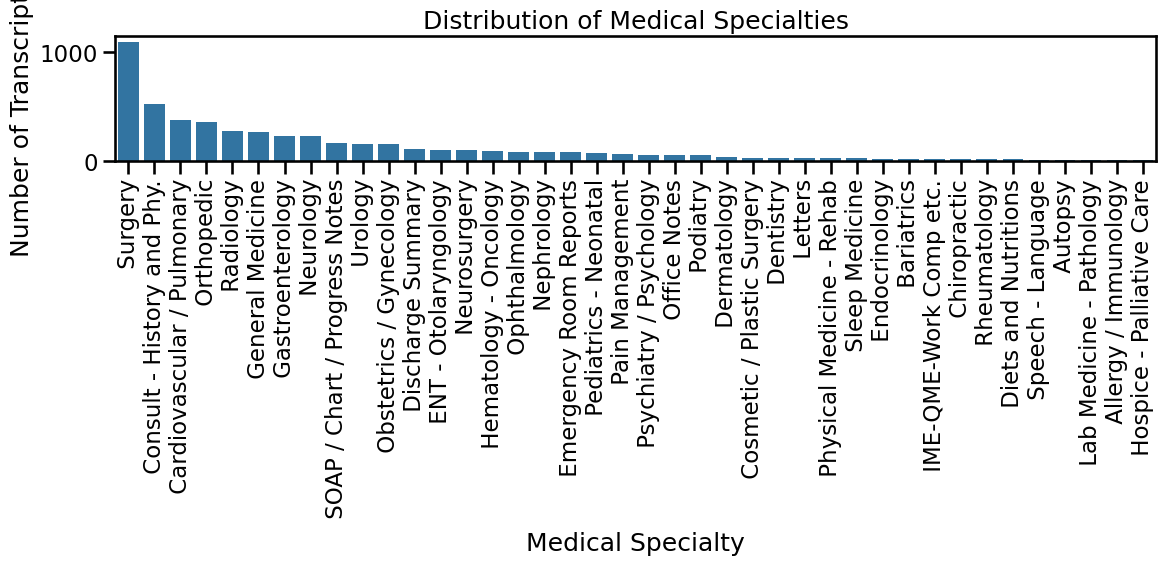

In [193]:
#Bar Plot of Most Common Medical Specialties
specialty_counts = df['medical_specialty'].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=specialty_counts.index, y=specialty_counts.values)
plt.title('Distribution of Medical Specialties')
plt.xlabel('Medical Specialty')
plt.ylabel('Number of Transcriptions')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

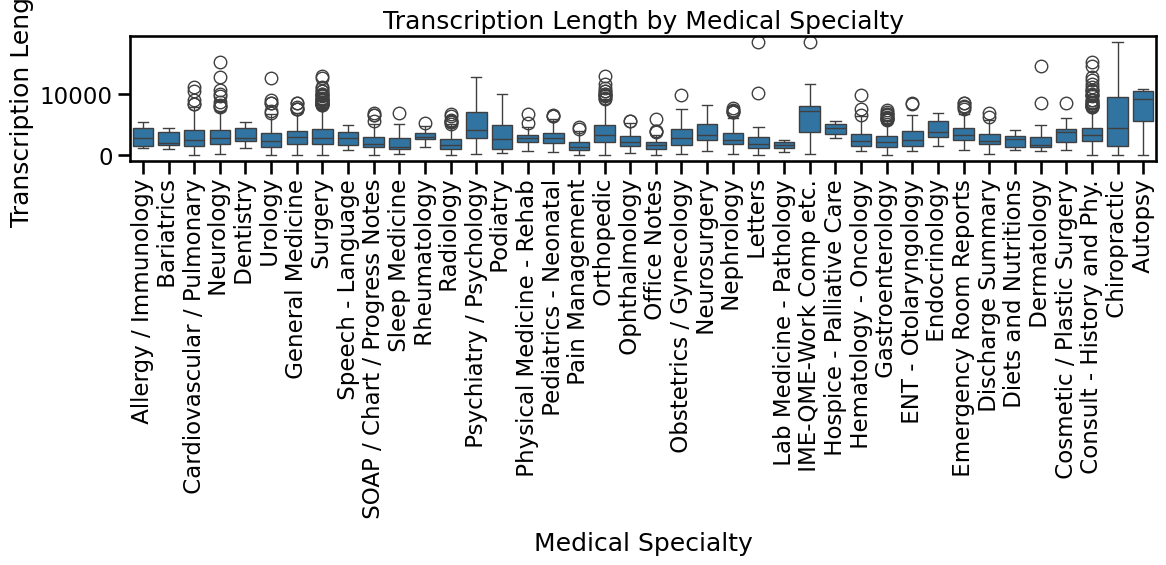

In [194]:
df['transcription_length'] = df['transcription'].apply(len)
plt.figure(figsize=(12, 6))
sns.boxplot(x='medical_specialty', y='transcription_length', data=df)
plt.title('Transcription Length by Medical Specialty')
plt.xlabel('Medical Specialty')
plt.ylabel('Transcription Length')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [195]:
# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\H468030\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\H468030\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\H468030\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [196]:
#stop_words = set(stopwords.words('english'))
#lemmatizer = WordNetLemmatizer()
# Function to preprocess text
#def preprocess_text(text):
    #if not isinstance(text, str):
     #return ''
    #tokens = word_tokenize(text.lower())
    #words = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    #return " ".join(words)

In [197]:
def preprocess_text(text):
    if not isinstance(text, str):
        return ''
    # Remove punctuation and convert to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation)).lower()
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in ENGLISH_STOP_WORDS])
    return text

In [198]:
df['cleaned_transcription'] = df['transcription'].apply(preprocess_text)

In [199]:
#Use TF-IDF to identify important terms within each medical specialty.
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=10)

# Fit and transform the cleaned transcriptions
X_tfidf = vectorizer.fit_transform(df['cleaned_transcription'])

# Get the feature names (terms)
terms = vectorizer.get_feature_names_out()

In [200]:
# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=terms)

# Add the medical specialty column
tfidf_df['medical_specialty'] = df['medical_specialty']

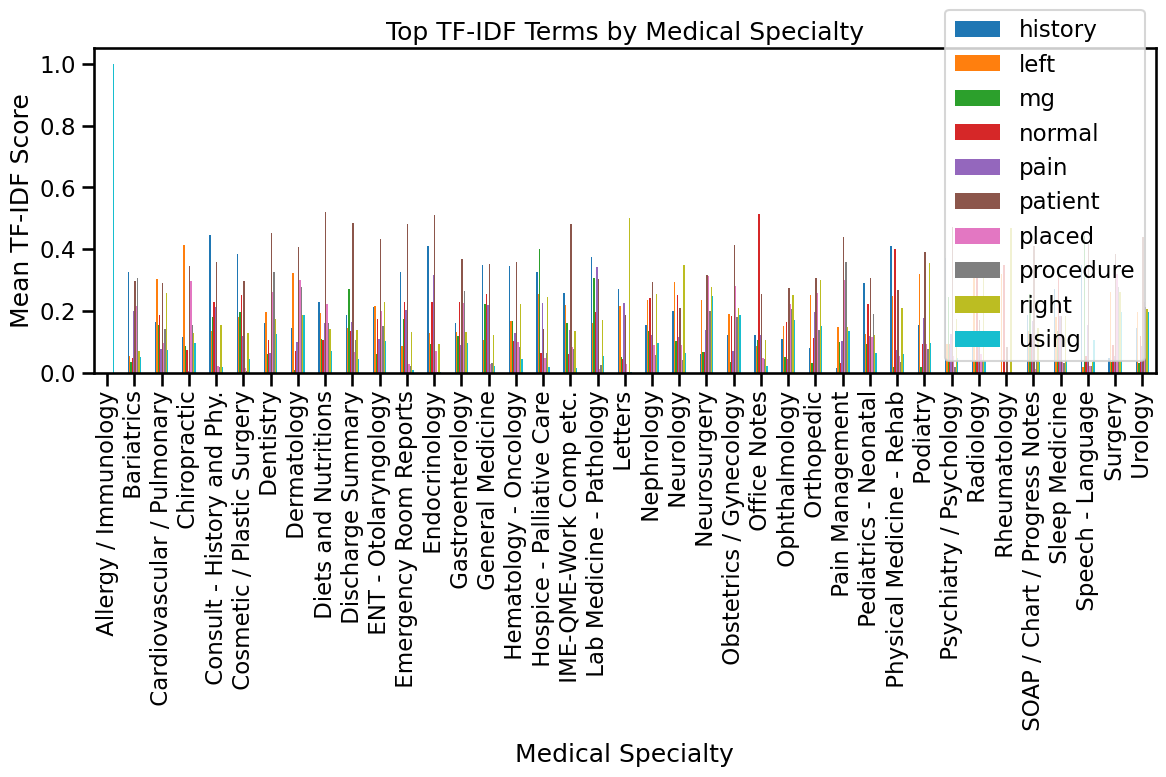

In [201]:
#Plot the most common used words against the medical specialty using the TFIDF Score 

# Group by medical specialty and calculate mean TF-IDF scores
mean_tfidf = tfidf_df.groupby('medical_specialty').mean()

# Plot the top terms for each specialty
mean_tfidf.plot(kind='bar', figsize=(12, 8))
plt.title('Top TF-IDF Terms by Medical Specialty')
plt.ylabel('Mean TF-IDF Score')
plt.xlabel('Medical Specialty')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\H468030\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


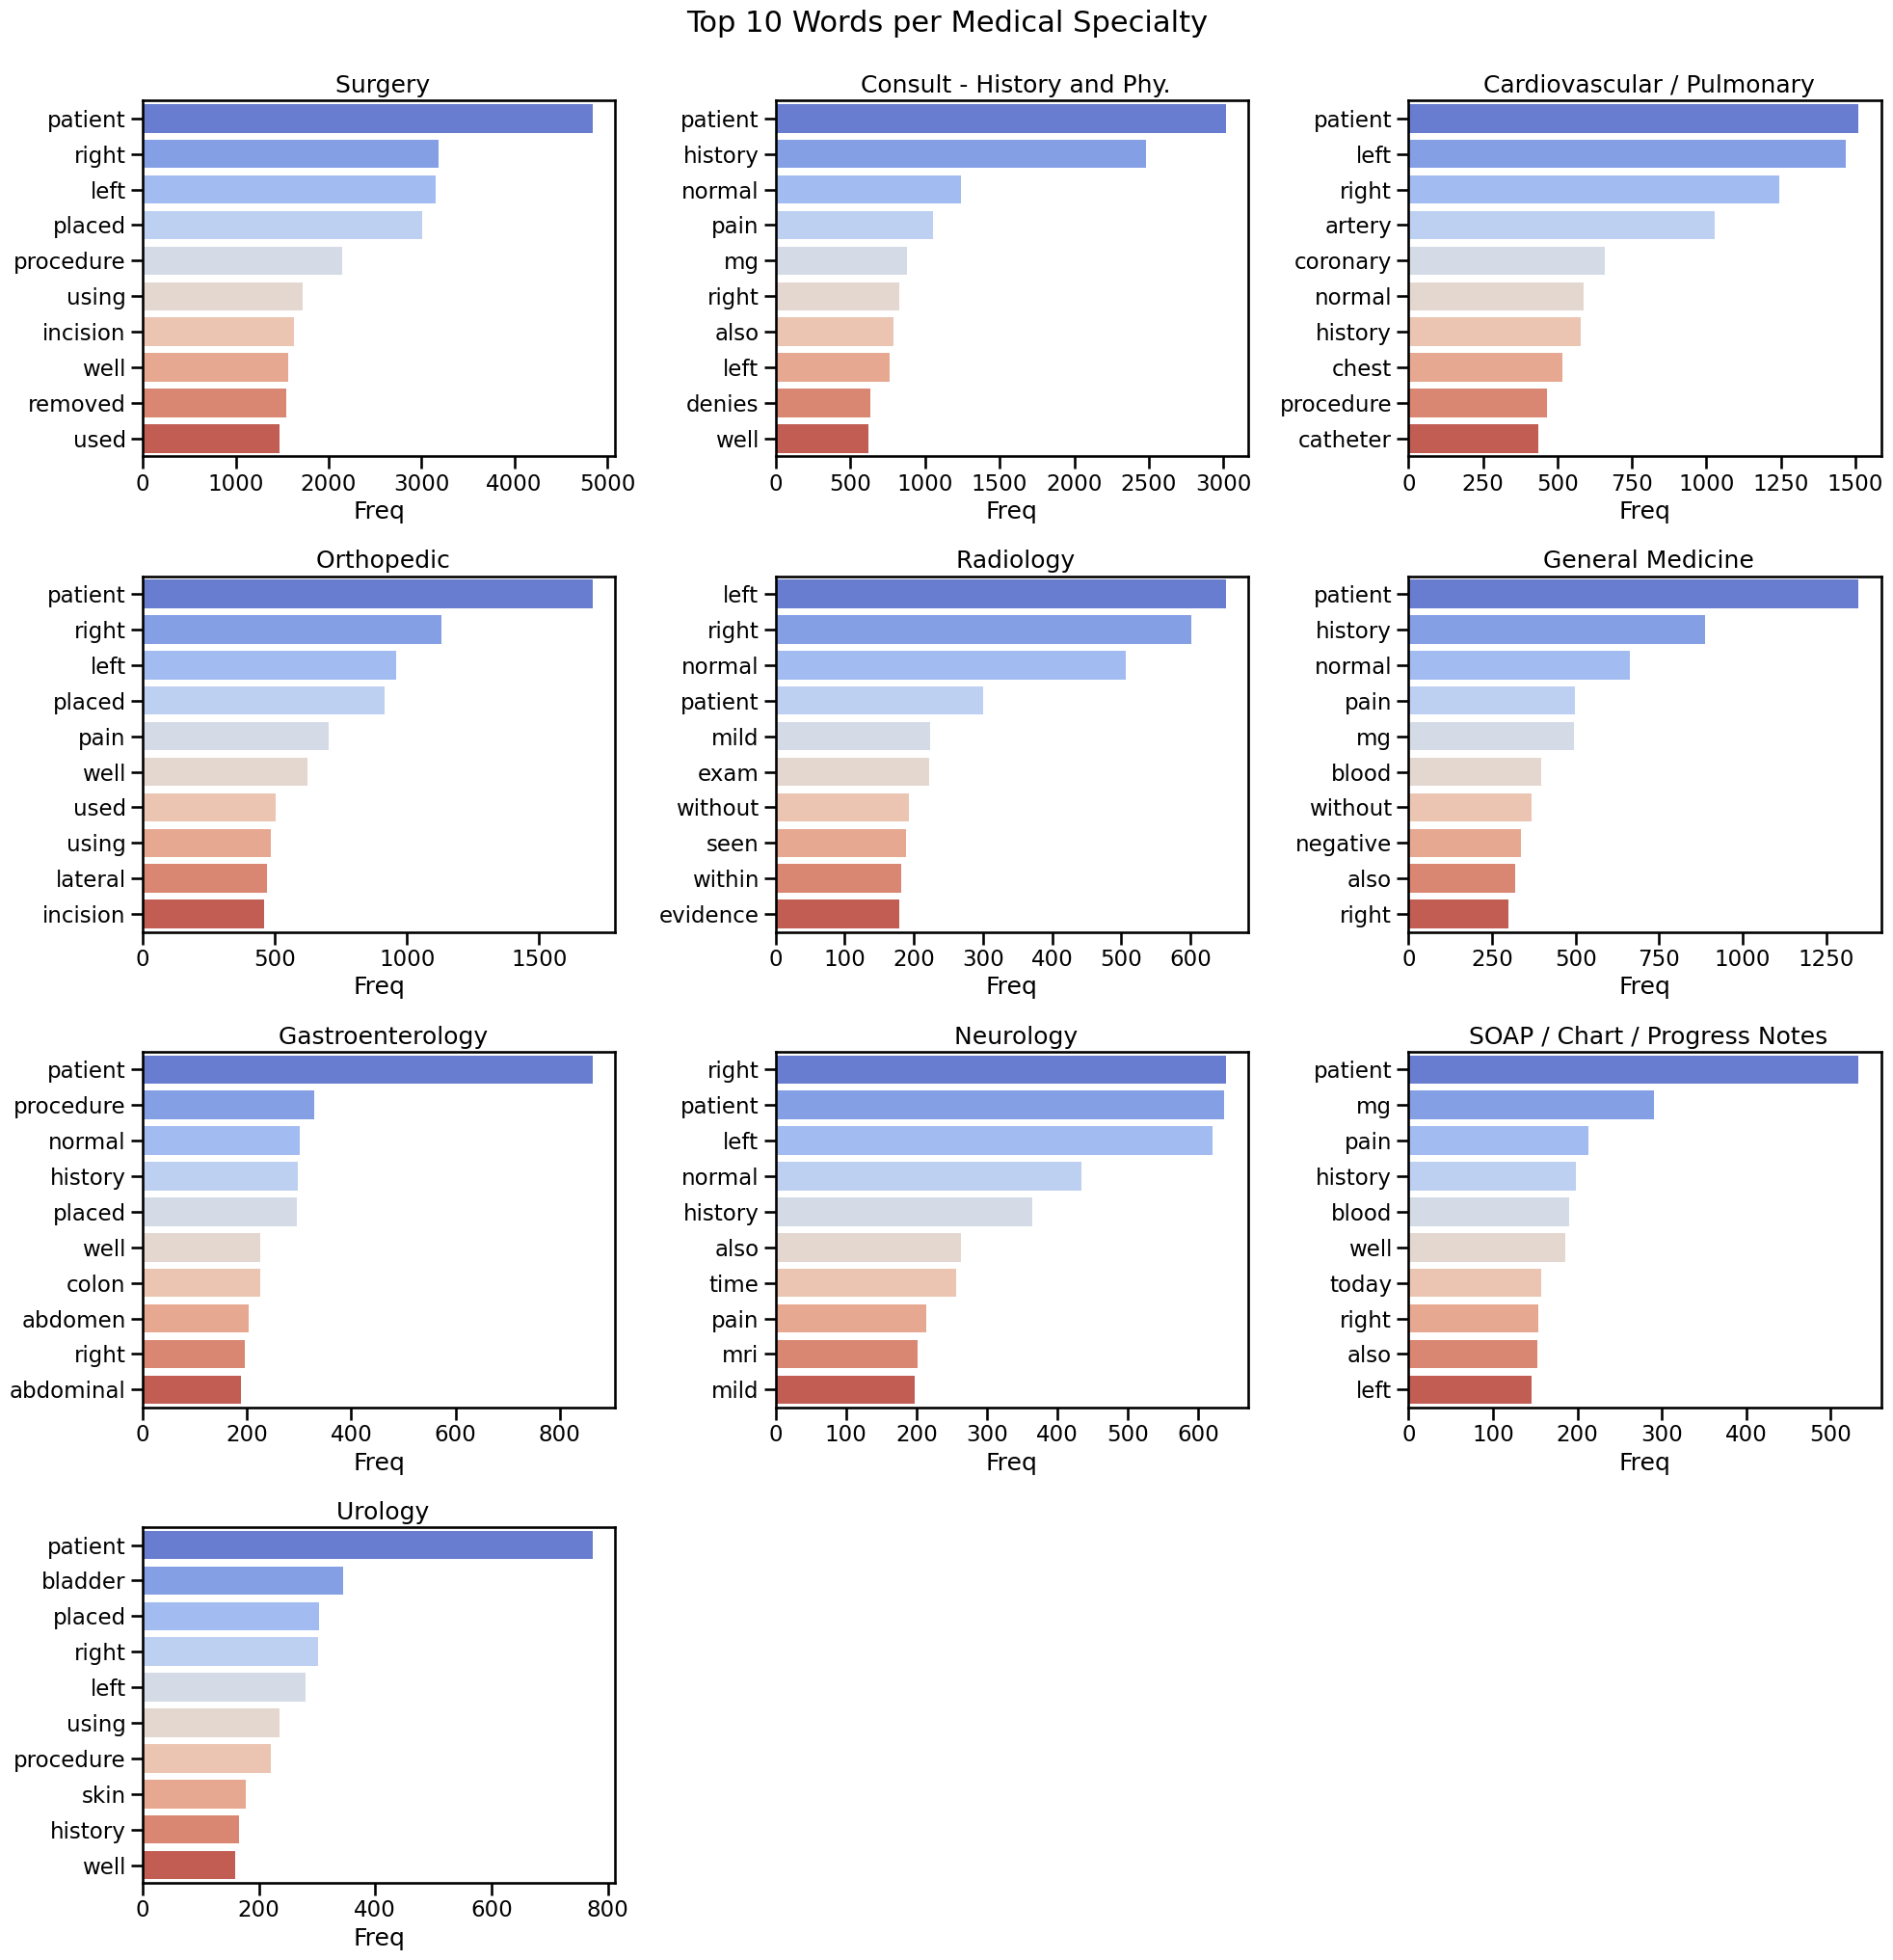

In [202]:

# Setup
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Get top 10 specialties
top_specialties = df['medical_specialty'].value_counts().head(10).index

# Create subplots - 4 rows x 3 columns (will leave 2 blank at end)
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))
axes = axes.flatten()  # Flatten for easy indexing

# Plot each specialty
for i, specialty in enumerate(top_specialties):
    subset = df[df['medical_specialty'] == specialty]['transcription'].dropna()

    tokens = " ".join(subset).lower().translate(str.maketrans("", "", string.punctuation)).split()
    filtered_tokens = [word for word in tokens if word not in stop_words and word.isalpha()]

    word_freq = Counter(filtered_tokens).most_common(10)

    if word_freq:
        words, counts = zip(*word_freq)
        sns.barplot(x=list(counts), y=list(words), ax=axes[i], palette='coolwarm')
        axes[i].set_title(f"{specialty}")
        axes[i].set_xlabel("Freq")
        axes[i].set_ylabel("")
    else:
        axes[i].text(0.5, 0.5, 'No Data', ha='center', va='center')
        axes[i].set_title(f"{specialty}")

# Hide any unused axes
for j in range(len(top_specialties), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Top 10 Words per Medical Specialty", fontsize=22, y=1.02)
plt.show()

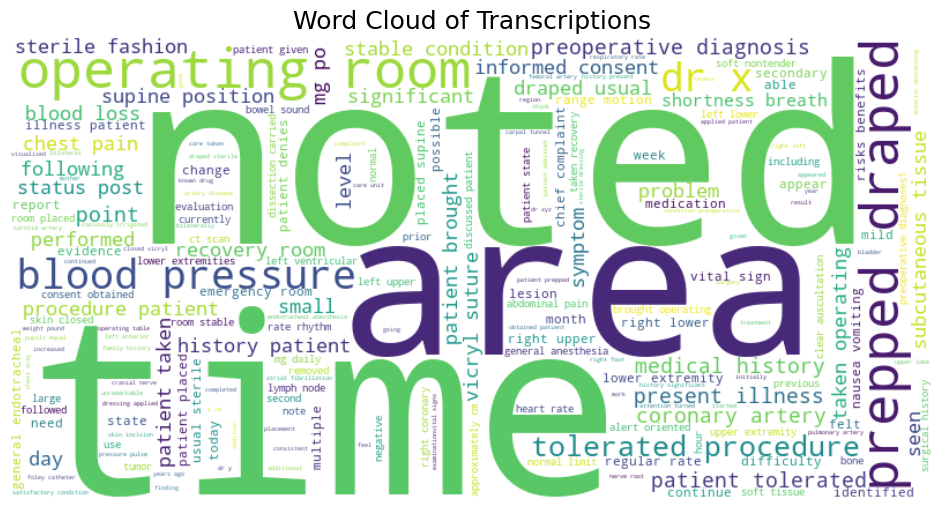

In [203]:
text = " ".join(df['cleaned_transcription'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Transcriptions")
plt.show()

In [204]:
# Initialize model
kw_model = KeyBERT()

In [205]:
def extract_keywords(text, top_n=5):
    """Extract top_n keywords from a given text."""
    return kw_model.extract_keywords(text, top_n=top_n)

In [206]:
df['keywords'] = df['transcription'].apply(extract_keywords)

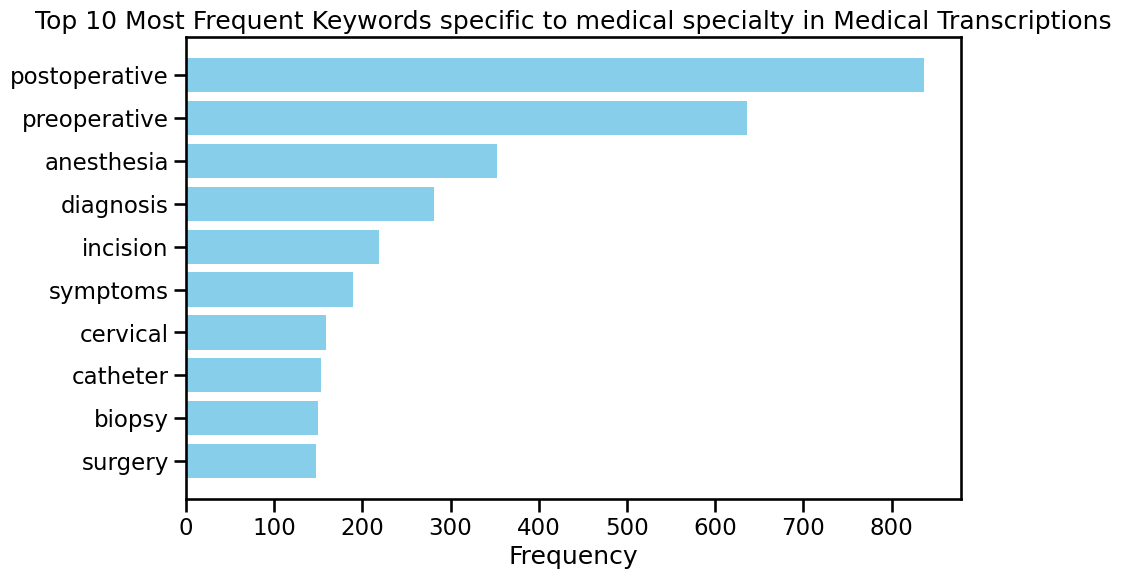

In [207]:
# Flatten the list of keywords
all_keywords = [keyword for sublist in df['keywords'] for keyword, _ in sublist]

# Count occurrences of each keyword
keyword_counts = Counter(all_keywords)

# Get the 10 most common keywords
common_keywords = keyword_counts.most_common(10)

# Separate the keywords and their counts
keywords, counts = zip(*common_keywords)

# Plot the results
plt.figure(figsize=(10, 6))
plt.barh(keywords, counts, color='skyblue')
plt.xlabel('Frequency')
plt.title('Top 10 Most Frequent Keywords specific to medical specialty in Medical Transcriptions')
plt.gca().invert_yaxis()
plt.show()

In [208]:
# Encode the target variable
label_encoder = LabelEncoder()
df['medical_specialty'] = label_encoder.fit_transform(df['medical_specialty'])

# Text Feature Extraction
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = tfidf_vectorizer.fit_transform(df['transcription']).toarray()
y = df['medical_specialty']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Multinomial Naive Bayes classifier
model = MultinomialNB()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.37
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         2
           3       0.44      0.34      0.39        79
           4       0.00      0.00      0.00         2
           5       0.29      0.95      0.45       111
           6       0.00      0.00      0.00         7
           7       0.00      0.00      0.00         8
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00        23
          11       0.00      0.00      0.00        32
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00        45
          15       0.00      0.00      0.00        44
          16       0.00      0.00      0.00        19
          17

C:\Users\H468030\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\H468030\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\H468030\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [209]:
# Train-test split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['transcription'].tolist(), df['medical_specialty'].tolist(), test_size=0.2, random_state=42)

# Load ClinicalBERT tokenizer
tokenizer = BertTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

# Tokenize text
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

# Convert to HuggingFace Datasets
train_dataset = Dataset.from_dict({**train_encodings, "labels": train_labels})
test_dataset = Dataset.from_dict({**test_encodings, "labels": test_labels})

# Load ClinicalBERT model
model = BertForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", num_labels=len(label_encoder.classes_))

training_args = TrainingArguments(
    output_dir='./results',
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    logging_dir='./logs',
    do_eval=True,
    save_steps=500,
    eval_steps=500,
    save_total_limit=1,
    logging_steps=50
)

# Define data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

# Train model
trainer.train()

# Make predictions
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

# Evaluate model
mse = mean_squared_error(test_labels, preds)
acc = accuracy_score(test_labels, preds)
r2 = r2_score(test_labels, preds)

print(f"Mean Squared Error: {mse}")
print(f"Accuracy: {acc}")
print(f"R² Score: {r2}")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.26.0`: Please run `pip install transformers[torch]` or `pip install 'accelerate>=0.26.0'`